In [1]:
#mount google drive when on google colaboratory

from google.colab import drive
drive.mount('/content/drive')

#set repo path and check repo status
repo_path = '/content/drive/MyDrive/geomsha/'
%cd /content/drive/MyDrive/geomsha/
!git status


Mounted at /content/drive
/content/drive/MyDrive/geomsha
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [1]:
#initialize environment, load modules/libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#import python code from seperate files
from utils.generators import gen_shapes, gen_noise, gen_image, gen_details
from utils.helpers import gen_grid_image

rnd=np.random.default_rng(31)


In [25]:
num_images=2

num_shapes=64
max_radius=1/20
min_radius=1/40

num_noise=300
max_line=1/20
min_line=1/80

im_size=1024
max_lw=0.15
min_lw=0.1

radius = int(max_radius*im_size)+1
detail_im_size = 2*radius+1

fluct=0

In [26]:
images = []
labels = []
details = []

for i in range(num_images) :
    shapes = gen_shapes(rnd, num_shapes, max_radius, min_radius, False, False)
    noise = gen_noise(rnd, num_noise, max_line, min_line)
    img, sha, nse = gen_image(shapes, noise, rnd, im_size, max_lw, min_lw, False)
    focus = gen_details(detail_im_size, sha, img, rnd, fluct)
    images.append(img)
    labels.append(sha)
    details.append(focus)

plt.close()

np.savez_compressed('data/data.npz', images=images, labels=labels, details=details)

In [27]:
loaded  = np.load('data/data.npz')
images = loaded['images']
labels = loaded['labels']
details = loaded['details']

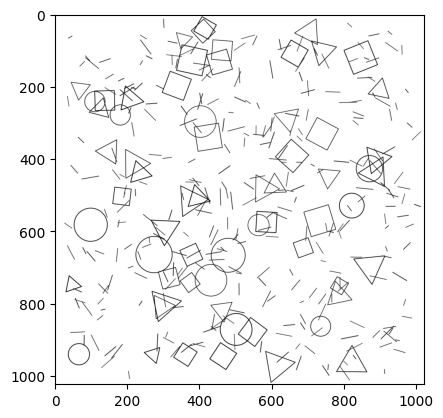

In [28]:
image=images[0]

fig = plt.figure(figsize=(image.shape[1],image.shape[0]),dpi=1)
fig.figimage(image, cmap='gray')
fig.savefig('data/tmp_image.png')
plt.close()

plt.imshow(mpimg.imread('data/tmp_image.png'))

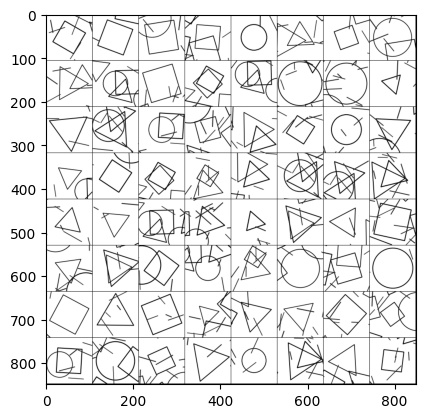

In [29]:
image=images[0]
detail=details[0]

grid = (8,8)
grid_image, grid_pos = gen_grid_image(detail, grid)

fig = plt.figure(figsize=(grid_image.shape[1],grid_image.shape[0]),dpi=1)
fig.figimage(grid_image, cmap='gray')
fig.savefig('data/tmp_grid.png')
plt.close()

plt.imshow(mpimg.imread('data/tmp_grid.png'))

In [20]:
label=labels[0]

print("\nposition : shape : [size, rotation, line_width]")
np.set_printoptions(precision=3, suppress=True)
for i in range(grid[0]*grid[1]):
    print(f"{grid_pos[i]} : {int(label[i][0])} {label[i][3:]}")


position : shape : [size, rotation, line_width]
(0, 0) : 4 [39.23   0.812  0.127]
(0, 1) : 4 [26.801  0.564  0.101]
(0, 2) : 4 [39.195  1.285  0.111]
(0, 3) : 3 [29.175  1.55   0.148]
(0, 4) : 2 [45.997  0.     0.113]
(1, 0) : 4 [28.523  0.864  0.118]
(1, 1) : 2 [50.435  0.     0.102]
(1, 2) : 4 [29.721  1.075  0.107]
(1, 3) : 3 [42.225  0.359  0.106]
(1, 4) : 4 [40.577  0.662  0.139]
(2, 0) : 2 [47.243  0.     0.144]
(2, 1) : 2 [26.841  0.     0.127]
(2, 2) : 4 [44.772  0.301  0.142]
(2, 3) : 4 [28.752  1.244  0.132]
(2, 4) : 3 [47.372  1.688  0.105]
(3, 0) : 3 [36.419  1.432  0.146]
(3, 1) : 3 [39.814  0.459  0.124]
(3, 2) : 3 [30.512  1.973  0.149]
(3, 3) : 2 [37.419  0.     0.137]
(3, 4) : 4 [42.891  0.608  0.109]
(4, 0) : 3 [39.231  0.161  0.136]
(4, 1) : 2 [32.819  0.     0.134]
(4, 2) : 2 [28.326  0.     0.134]
(4, 3) : 4 [35.066  0.066  0.126]
(4, 4) : 2 [48.785  0.     0.106]
